In [1]:
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.models import Sequential
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob
from dask import compute, delayed
import dask.threaded
import time
from scipy.stats import pearsonr

Using TensorFlow backend.


In [2]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

mallet_model=gensim.models.LdaModel.load('./models/model-050')

pprint(mallet_model.print_topics(50,30))

##unwrap the model
model=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50)

[(0,
  '0.064*"deal" + 0.047*"iran" + 0.024*"israel" + 0.022*"russia" + '
  '0.017*"agreement" + 0.016*"nuclear" + 0.014*"world" + 0.013*"war" + '
  '0.011*"bomb" + 0.011*"russian" + 0.011*"support" + 0.010*"country" + '
  '0.010*"jewish" + 0.010*"sanction" + 0.009*"putin" + 0.009*"peace" + '
  '0.008*"iranian" + 0.008*"nation" + 0.008*"israeli" + 0.008*"cuba" + '
  '0.008*"international" + 0.007*"jew" + 0.007*"ukraine" + 0.007*"west" + '
  '0.007*"negotiate" + 0.006*"palestinian" + 0.006*"attack" + 0.006*"leader" + '
  '0.006*"power" + 0.006*"japan"'),
 (1,
  '0.065*"question" + 0.061*"point" + 0.033*"answer" + 0.030*"fact" + '
  '0.029*"wrong" + 0.028*"agree" + 0.027*"argument" + 0.023*"reason" + '
  '0.018*"case" + 0.017*"base" + 0.015*"correct" + 0.015*"simply" + '
  '0.013*"make" + 0.012*"suggest" + 0.011*"view" + 0.011*"assume" + '
  '0.011*"completely" + 0.011*"clear" + 0.011*"argue" + 0.010*"simple" + '
  '0.010*"statement" + 0.009*"disagree" + 0.009*"response" + 0.009*"opinion

In [3]:
##a clearer rendering of topic words
topics=[topic[1] for topic in model.show_topics(num_topics=50,num_words=30, formatted=False)]
topwords=[]
f=open("./plots/"+str(50)+"topicwords.csv","w")
for topic in topics:
    topicwords=[]
    for topicword in topic:
        topicwords.append(topicword[0])
        f.write(topicword[0]+",")
        topicstring="  ".join(topicwords)
    f.write("\n")
    topwords.append(topicstring)
f.close()
for idx, topword in enumerate(topwords):
    print ("Topic"+str(idx)+"\n"+topword+"\n_____________________________________________________________________________________________________________________")
    print ()

    
    
    
    

Topic0
deal  iran  israel  russia  agreement  nuclear  world  war  bomb  russian  support  country  jewish  sanction  putin  peace  iranian  nation  israeli  cuba  international  jew  ukraine  west  negotiate  palestinian  attack  leader  power  japan
_____________________________________________________________________________________________________________________

Topic1
question  point  answer  fact  wrong  agree  argument  reason  case  base  correct  simply  make  suggest  view  assume  completely  clear  argue  simple  statement  disagree  response  opinion  reasonable  logic  position  side  present  give
_____________________________________________________________________________________________________________________

Topic2
gun  people  control  kill  fear  act  violence  shoot  stop  hand  carry  fire  murder  death  threat  weapon  dangerous  happen  attack  nra  responsible  public  tragedy  blame  mass  victim  safety  protect  afraid  safe
___________________________

In [4]:
##vaxx files
files = glob.glob('../documents/vaxx/*.txt')
print(len(files))
files=np.random.choice(files,int(len(files)))
print(len(files))
data = []
for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

1101
1101


In [4]:
files = glob.glob('../documents/comments/comments/*.txt')
print(len(files))
files=np.random.choice(files,int(len(files)/50))
print(len(files))
data = []
for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

445441
8908


In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
start=time.time()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
end=time.time()
print('time used to construct bigrams',end-start)
# Faster way to get a sentence clubbed as a trigram/bigram
start=time.time()
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
end=time.time()
print('time used to construct Phrasors',end-start)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    values=[delayed(nlp)(" ".join(sent)) for sent in texts]
    docs=compute(*values,scheduling='threads')
    for doc in docs:
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
start=time.time()
data_words_nostops = remove_stopwords(data_words)
end=time.time()
print('time used to remove stopwords',end-start)
# Form Bigrams
start=time.time()
data_words_bigrams = make_bigrams(data_words_nostops)
end=time.time()
print('time used to make bigrams',end-start)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 9297925
# Do lemmatization keeping only noun, adj, vb, adv
start=time.time()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
end=time.time()
print('time used to lemmatize words',end-start)
print(data_lemmatized[:1])

time used to construct bigrams 6.80098295211792
time used to construct Phrasors 10.101285219192505
['you', 'didn', 'list', 'the', 'ultimate', 'and', 'most', 'significant', 'bit', 'of', 'subjective', 'opinion', 'that', 'cannot', 'be', 'extracted', 'from', 'journalism', 'the', 'simple', 'choice', 'of', 'what', 'gets', 'covered', 'choosing', 'to', 'shine', 'light', 'or', 'not', 'on', 'something', 'is', 'the', 'ultimate', 'subjectivity', 'and', 'every', 'outlet', 'does', 'it']
time used to remove stopwords 2.7174110412597656
time used to make bigrams 1.372959852218628
time used to lemmatize words 81.59417605400085
[['list', 'ultimate', 'significant', 'bit', 'subjective', 'opinion', 'can', 'not', 'extract', 'journalism', 'simple', 'choice', 'get', 'cover', 'choose', 'shine', 'light', 'something', 'ultimate', 'subjectivity', 'outlet']]


In [6]:
# Create Dictionary
id2word = mallet_model.id2word

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
start=time.time()
values = [delayed(id2word.doc2bow)(text) for text in texts]
corpus=compute(*values, scheduler='threads')
end=time.time()
print('time used', end-start)
# View
print(corpus[:1])

X=np.asarray(model.inference(corpus)[0])
num_topics=len(X[0])
##normalize it
X=(X.T/np.sum(X,axis=1)).T
Y=np.asarray([len(text) for text in texts])

time used 5.376482009887695
([(35, 1), (97, 1), (125, 1), (505, 1), (562, 1), (776, 1), (814, 1), (842, 1), (1477, 1), (1487, 1), (1604, 1), (1966, 1), (3173, 1), (3767, 2), (6326, 1), (9229, 1), (12447, 1), (13112, 1), (16176, 1), (17562, 1)],)


In [7]:
##print((X[idx]))
topics4X=np.argmax(X[1:80],axis=1)
print(topics4X)
idx=4
topic4X=np.argmax(X[idx])
print(" ".join(data_words[idx]))
print(model.show_topic(topic4X))
##minor problem: the token br is not removed

[34 11 17  0 14  2 11  6 25  1 32  4 29 25 39 13 27 49 29  1 43 36 47 32
 21 31 35 35 43 22 31 11 49 45 31 37 41 31 41 29  2  1 25 42 37 42 26  8
  7 18 33 15 18 25 18  5  4 25  9  8 49 23 27 16 36 28  6  5  9  0 29 20
 12 30  2  0 11  2  9]
neither
[('deal', 0.06351775791253927), ('iran', 0.04667103855313569), ('israel', 0.024402029475718776), ('russia', 0.021640838021606327), ('agreement', 0.017171159355261797), ('nuclear', 0.01553170192938253), ('world', 0.014296068753667209), ('war', 0.01319849515065751), ('bomb', 0.011396817726849136), ('russian', 0.011362302833672731)]


In [8]:
##don't randomly run this. this will overwrite the mode. If you accidentally ran this, run the load function 3 blocks below
normalized_model=Sequential()
normalized_dense_layer=Dense(100,input_shape=[num_topics,],activation="relu")
normalized_dense_layer_2=Dense(1)
normalized_model.add(normalized_dense_layer)
normalized_model.add(normalized_dense_layer_2)
normalized_model.compile(loss="mean_squared_error", optimizer='adam', metrics=['accuracy'])
normalized_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
for i in range (5000):
    print(i)
    normalized_model.fit(X, Y, epochs=50,verbose=1, batch_size=5000)
    print("training set(after", i*50+50, "iterations) :",str(pearsonr(normalized_model.predict(X).squeeze(),Y)[0])[0:5])
    
    
    

0
Epoch 1/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.8770 - acc: 0.0480
Epoch 2/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.8432 - acc: 0.0485
Epoch 3/50
8908/8908 [==============================] - 0s 2us/step - loss: 196.8208 - acc: 0.0482
Epoch 4/50
8908/8908 [==============================] - 0s 4us/step - loss: 196.7978 - acc: 0.0487
Epoch 5/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.7722 - acc: 0.0487
Epoch 6/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.7493 - acc: 0.0488
Epoch 7/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.7274 - acc: 0.0487
Epoch 8/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.7011 - acc: 0.0492
Epoch 9/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.6808 - acc: 0.0486
Epoch 10/50
8908/8908 [==============================] - 0s 3us/step - loss: 196.6596 - acc: 0.0484
Epoch 1

8908/8908 [==============================] - 0s 3us/step - loss: 193.1633 - acc: 0.0498
Epoch 14/50
8908/8908 [==============================] - 0s 4us/step - loss: 193.1381 - acc: 0.0500
Epoch 15/50
8908/8908 [==============================] - 0s 3us/step - loss: 193.1177 - acc: 0.0496
Epoch 16/50
8908/8908 [==============================] - 0s 3us/step - loss: 193.1136 - acc: 0.0502
Epoch 17/50
8908/8908 [==============================] - 0s 4us/step - loss: 193.0733 - acc: 0.0496
Epoch 18/50
8908/8908 [==============================] - 0s 4us/step - loss: 193.0511 - acc: 0.0500
Epoch 19/50
8908/8908 [==============================] - 0s 5us/step - loss: 193.0454 - acc: 0.0501
Epoch 20/50
8908/8908 [==============================] - 0s 4us/step - loss: 193.0079 - acc: 0.0505
Epoch 21/50
8908/8908 [==============================] - 0s 4us/step - loss: 192.9874 - acc: 0.0509
Epoch 22/50
8908/8908 [==============================] - 0s 3us/step - loss: 192.9591 - acc: 0.0501
Epoch 23/50


8908/8908 [==============================] - 0s 3us/step - loss: 189.4424 - acc: 0.0487
Epoch 26/50
8908/8908 [==============================] - 0s 3us/step - loss: 189.4130 - acc: 0.0497
Epoch 27/50
8908/8908 [==============================] - 0s 2us/step - loss: 189.3982 - acc: 0.0501
Epoch 28/50
8908/8908 [==============================] - 0s 3us/step - loss: 189.3773 - acc: 0.0496
Epoch 29/50
8908/8908 [==============================] - 0s 3us/step - loss: 189.3487 - acc: 0.0503
Epoch 30/50
8908/8908 [==============================] - 0s 2us/step - loss: 189.3267 - acc: 0.0493
Epoch 31/50
8908/8908 [==============================] - 0s 2us/step - loss: 189.3070 - acc: 0.0488
Epoch 32/50
8908/8908 [==============================] - 0s 2us/step - loss: 189.2925 - acc: 0.0484
Epoch 33/50
8908/8908 [==============================] - 0s 3us/step - loss: 189.2600 - acc: 0.0489
Epoch 34/50
8908/8908 [==============================] - 0s 3us/step - loss: 189.2343 - acc: 0.0492
Epoch 35/50


8908/8908 [==============================] - 0s 3us/step - loss: 185.8950 - acc: 0.0493
Epoch 38/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.8723 - acc: 0.0486
Epoch 39/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.8609 - acc: 0.0491
Epoch 40/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.8244 - acc: 0.0488
Epoch 41/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.8163 - acc: 0.0486
Epoch 42/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.7918 - acc: 0.0486
Epoch 43/50
8908/8908 [==============================] - 0s 3us/step - loss: 185.7624 - acc: 0.0483
Epoch 44/50
8908/8908 [==============================] - 0s 4us/step - loss: 185.7430 - acc: 0.0486
Epoch 45/50
8908/8908 [==============================] - 0s 4us/step - loss: 185.7257 - acc: 0.0487
Epoch 46/50
8908/8908 [==============================] - 0s 4us/step - loss: 185.6995 - acc: 0.0487
Epoch 47/50


8908/8908 [==============================] - 0s 3us/step - loss: 182.5321 - acc: 0.0487
Epoch 50/50
8908/8908 [==============================] - 0s 3us/step - loss: 182.5171 - acc: 0.0484
training set(after 600 iterations) : 0.910
13
Epoch 1/50
8908/8908 [==============================] - 0s 5us/step - loss: 182.4954 - acc: 0.0477
Epoch 2/50
8908/8908 [==============================] - 0s 4us/step - loss: 182.4737 - acc: 0.0488
Epoch 3/50
8908/8908 [==============================] - 0s 3us/step - loss: 182.4512 - acc: 0.0487
Epoch 4/50
8908/8908 [==============================] - 0s 4us/step - loss: 182.4310 - acc: 0.0488
Epoch 5/50
8908/8908 [==============================] - 0s 4us/step - loss: 182.4128 - acc: 0.0487
Epoch 6/50
8908/8908 [==============================] - 0s 3us/step - loss: 182.3929 - acc: 0.0492
Epoch 7/50
8908/8908 [==============================] - 0s 3us/step - loss: 182.3748 - acc: 0.0487
Epoch 8/50
8908/8908 [==============================] - 0s 3us/step - los

8908/8908 [==============================] - 0s 3us/step - loss: 179.3320 - acc: 0.0488
Epoch 12/50
8908/8908 [==============================] - 0s 3us/step - loss: 179.3093 - acc: 0.0484
Epoch 13/50
8908/8908 [==============================] - 0s 2us/step - loss: 179.3134 - acc: 0.0486
Epoch 14/50
8908/8908 [==============================] - 0s 2us/step - loss: 179.2891 - acc: 0.0483
Epoch 15/50
8908/8908 [==============================] - 0s 3us/step - loss: 179.2533 - acc: 0.0480
Epoch 16/50
8908/8908 [==============================] - 0s 2us/step - loss: 179.2318 - acc: 0.0486
Epoch 17/50
8908/8908 [==============================] - 0s 3us/step - loss: 179.2253 - acc: 0.0492
Epoch 18/50
8908/8908 [==============================] - 0s 3us/step - loss: 179.1948 - acc: 0.0492
Epoch 19/50
8908/8908 [==============================] - 0s 4us/step - loss: 179.1803 - acc: 0.0494
Epoch 20/50
8908/8908 [==============================] - 0s 4us/step - loss: 179.1533 - acc: 0.0487
Epoch 21/50


8908/8908 [==============================] - 0s 3us/step - loss: 176.3028 - acc: 0.0505
Epoch 24/50
8908/8908 [==============================] - 0s 3us/step - loss: 176.2830 - acc: 0.0510
Epoch 25/50
8908/8908 [==============================] - 0s 3us/step - loss: 176.2687 - acc: 0.0509
Epoch 26/50
8908/8908 [==============================] - 0s 5us/step - loss: 176.2486 - acc: 0.0509
Epoch 27/50
8908/8908 [==============================] - 0s 5us/step - loss: 176.2358 - acc: 0.0507
Epoch 28/50
8908/8908 [==============================] - 0s 4us/step - loss: 176.2201 - acc: 0.0504
Epoch 29/50
8908/8908 [==============================] - 0s 5us/step - loss: 176.1955 - acc: 0.0503
Epoch 30/50
8908/8908 [==============================] - 0s 4us/step - loss: 176.1857 - acc: 0.0504
Epoch 31/50
8908/8908 [==============================] - 0s 3us/step - loss: 176.1717 - acc: 0.0506
Epoch 32/50
8908/8908 [==============================] - 0s 4us/step - loss: 176.1436 - acc: 0.0503
Epoch 33/50


8908/8908 [==============================] - 0s 3us/step - loss: 173.4571 - acc: 0.0521
Epoch 35/50
8908/8908 [==============================] - 0s 5us/step - loss: 173.4339 - acc: 0.0519
Epoch 36/50
8908/8908 [==============================] - 0s 7us/step - loss: 173.4324 - acc: 0.0516
Epoch 37/50
8908/8908 [==============================] - 0s 4us/step - loss: 173.4015 - acc: 0.0523
Epoch 38/50
8908/8908 [==============================] - 0s 4us/step - loss: 173.3843 - acc: 0.0516
Epoch 39/50
8908/8908 [==============================] - 0s 4us/step - loss: 173.3663 - acc: 0.0525
Epoch 40/50
8908/8908 [==============================] - 0s 4us/step - loss: 173.3530 - acc: 0.0520
Epoch 41/50
8908/8908 [==============================] - 0s 5us/step - loss: 173.3329 - acc: 0.0520
Epoch 42/50
8908/8908 [==============================] - 0s 3us/step - loss: 173.3109 - acc: 0.0513
Epoch 43/50
8908/8908 [==============================] - 0s 4us/step - loss: 173.3070 - acc: 0.0514
Epoch 44/50


8908/8908 [==============================] - 0s 2us/step - loss: 170.6486 - acc: 0.0512
Epoch 47/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.6202 - acc: 0.0515
Epoch 48/50
8908/8908 [==============================] - 0s 2us/step - loss: 170.6054 - acc: 0.0514
Epoch 49/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.5876 - acc: 0.0509
Epoch 50/50
8908/8908 [==============================] - 0s 2us/step - loss: 170.5676 - acc: 0.0510
training set(after 1250 iterations) : 0.916
26
Epoch 1/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.5590 - acc: 0.0515
Epoch 2/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.5316 - acc: 0.0512
Epoch 3/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.5101 - acc: 0.0514
Epoch 4/50
8908/8908 [==============================] - 0s 3us/step - loss: 170.4954 - acc: 0.0518
Epoch 5/50
8908/8908 [==============================] - 0s 3us/step -

8908/8908 [==============================] - 0s 3us/step - loss: 167.8295 - acc: 0.0509
Epoch 9/50
8908/8908 [==============================] - 0s 4us/step - loss: 167.8134 - acc: 0.0519
Epoch 10/50
8908/8908 [==============================] - 0s 3us/step - loss: 167.7860 - acc: 0.0521
Epoch 11/50
8908/8908 [==============================] - 0s 5us/step - loss: 167.7736 - acc: 0.0524
Epoch 12/50
8908/8908 [==============================] - 0s 5us/step - loss: 167.7472 - acc: 0.0520
Epoch 13/50
8908/8908 [==============================] - 0s 6us/step - loss: 167.7354 - acc: 0.0516
Epoch 14/50
8908/8908 [==============================] - 0s 4us/step - loss: 167.7313 - acc: 0.0514
Epoch 15/50
8908/8908 [==============================] - 0s 5us/step - loss: 167.7104 - acc: 0.0504
Epoch 16/50
8908/8908 [==============================] - 0s 3us/step - loss: 167.6873 - acc: 0.0514
Epoch 17/50
8908/8908 [==============================] - 0s 3us/step - loss: 167.6678 - acc: 0.0516
Epoch 18/50
8

8908/8908 [==============================] - 0s 2us/step - loss: 165.0385 - acc: 0.0513
Epoch 21/50
8908/8908 [==============================] - 0s 3us/step - loss: 165.0303 - acc: 0.0511
Epoch 22/50
8908/8908 [==============================] - 0s 2us/step - loss: 165.0140 - acc: 0.0521
Epoch 23/50
8908/8908 [==============================] - 0s 3us/step - loss: 164.9943 - acc: 0.0512
Epoch 24/50
8908/8908 [==============================] - 0s 2us/step - loss: 164.9709 - acc: 0.0515
Epoch 25/50
8908/8908 [==============================] - 0s 3us/step - loss: 164.9725 - acc: 0.0516
Epoch 26/50
8908/8908 [==============================] - 0s 4us/step - loss: 164.9359 - acc: 0.0518
Epoch 27/50
8908/8908 [==============================] - 0s 4us/step - loss: 164.9189 - acc: 0.0516
Epoch 28/50
8908/8908 [==============================] - 0s 3us/step - loss: 164.9058 - acc: 0.0515
Epoch 29/50
8908/8908 [==============================] - 0s 4us/step - loss: 164.8856 - acc: 0.0510
Epoch 30/50


8908/8908 [==============================] - 0s 3us/step - loss: 162.3609 - acc: 0.0534
Epoch 33/50
8908/8908 [==============================] - 0s 3us/step - loss: 162.3432 - acc: 0.0531
Epoch 34/50
8908/8908 [==============================] - 0s 2us/step - loss: 162.3289 - acc: 0.0528
Epoch 35/50
8908/8908 [==============================] - 0s 2us/step - loss: 162.3133 - acc: 0.0526
Epoch 36/50
8908/8908 [==============================] - 0s 2us/step - loss: 162.3002 - acc: 0.0530
Epoch 37/50
8908/8908 [==============================] - 0s 3us/step - loss: 162.2798 - acc: 0.0532
Epoch 38/50
8908/8908 [==============================] - 0s 4us/step - loss: 162.2653 - acc: 0.0534
Epoch 39/50
8908/8908 [==============================] - 0s 3us/step - loss: 162.2443 - acc: 0.0533
Epoch 40/50
8908/8908 [==============================] - 0s 3us/step - loss: 162.2287 - acc: 0.0521
Epoch 41/50
8908/8908 [==============================] - 0s 4us/step - loss: 162.2296 - acc: 0.0528
Epoch 42/50


8908/8908 [==============================] - 0s 3us/step - loss: 159.7891 - acc: 0.0538
Epoch 45/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.7733 - acc: 0.0539
Epoch 46/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.7585 - acc: 0.0538
Epoch 47/50
8908/8908 [==============================] - 0s 2us/step - loss: 159.7449 - acc: 0.0538
Epoch 48/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.7296 - acc: 0.0534
Epoch 49/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.7083 - acc: 0.0530
Epoch 50/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.6896 - acc: 0.0539
training set(after 1900 iterations) : 0.922
39
Epoch 1/50
8908/8908 [==============================] - 0s 4us/step - loss: 159.6763 - acc: 0.0532
Epoch 2/50
8908/8908 [==============================] - 0s 3us/step - loss: 159.6643 - acc: 0.0535
Epoch 3/50
8908/8908 [==============================] - 0s 3us/step

8908/8908 [==============================] - 0s 3us/step - loss: 157.2326 - acc: 0.0540
Epoch 7/50
8908/8908 [==============================] - 0s 4us/step - loss: 157.2221 - acc: 0.0547
Epoch 8/50
8908/8908 [==============================] - 0s 3us/step - loss: 157.2015 - acc: 0.0542
Epoch 9/50
8908/8908 [==============================] - 0s 3us/step - loss: 157.1847 - acc: 0.0535
Epoch 10/50
8908/8908 [==============================] - 0s 4us/step - loss: 157.1690 - acc: 0.0538
Epoch 11/50
8908/8908 [==============================] - 0s 4us/step - loss: 157.1571 - acc: 0.0542
Epoch 12/50
8908/8908 [==============================] - 0s 3us/step - loss: 157.1507 - acc: 0.0534
Epoch 13/50
8908/8908 [==============================] - 0s 3us/step - loss: 157.1279 - acc: 0.0540
Epoch 14/50
8908/8908 [==============================] - 0s 4us/step - loss: 157.1100 - acc: 0.0541
Epoch 15/50
8908/8908 [==============================] - 0s 3us/step - loss: 157.0992 - acc: 0.0541
Epoch 16/50
890

8908/8908 [==============================] - 0s 3us/step - loss: 154.7699 - acc: 0.0559
Epoch 19/50
8908/8908 [==============================] - 0s 3us/step - loss: 154.7560 - acc: 0.0558
Epoch 20/50
8908/8908 [==============================] - 0s 3us/step - loss: 154.7576 - acc: 0.0565
Epoch 21/50
8908/8908 [==============================] - 0s 6us/step - loss: 154.7369 - acc: 0.0561
Epoch 22/50
8908/8908 [==============================] - 0s 3us/step - loss: 154.7154 - acc: 0.0553
Epoch 23/50
8908/8908 [==============================] - 0s 2us/step - loss: 154.7041 - acc: 0.0558
Epoch 24/50
8908/8908 [==============================] - 0s 2us/step - loss: 154.6783 - acc: 0.0555
Epoch 25/50
8908/8908 [==============================] - 0s 3us/step - loss: 154.6645 - acc: 0.0558
Epoch 26/50
8908/8908 [==============================] - 0s 3us/step - loss: 154.6624 - acc: 0.0553
Epoch 27/50
8908/8908 [==============================] - 0s 4us/step - loss: 154.6472 - acc: 0.0566
Epoch 28/50


8908/8908 [==============================] - 0s 3us/step - loss: 152.4143 - acc: 0.0592
Epoch 31/50
8908/8908 [==============================] - 0s 5us/step - loss: 152.3794 - acc: 0.0583
Epoch 32/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.3747 - acc: 0.0603
Epoch 33/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.3452 - acc: 0.0606
Epoch 34/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.3410 - acc: 0.0593
Epoch 35/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.3164 - acc: 0.0588
Epoch 36/50
8908/8908 [==============================] - 0s 5us/step - loss: 152.3003 - acc: 0.0592
Epoch 37/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.2882 - acc: 0.0599
Epoch 38/50
8908/8908 [==============================] - 0s 3us/step - loss: 152.2752 - acc: 0.0602
Epoch 39/50
8908/8908 [==============================] - 0s 4us/step - loss: 152.2573 - acc: 0.0599
Epoch 40/50


8908/8908 [==============================] - 0s 4us/step - loss: 150.0863 - acc: 0.0595
Epoch 43/50
8908/8908 [==============================] - 0s 4us/step - loss: 150.0566 - acc: 0.0587
Epoch 44/50
8908/8908 [==============================] - 0s 4us/step - loss: 150.0428 - acc: 0.0589
Epoch 45/50
8908/8908 [==============================] - 0s 4us/step - loss: 150.0299 - acc: 0.0588
Epoch 46/50
8908/8908 [==============================] - 0s 4us/step - loss: 150.0156 - acc: 0.0587
Epoch 47/50
8908/8908 [==============================] - 0s 5us/step - loss: 150.0007 - acc: 0.0589
Epoch 48/50
8908/8908 [==============================] - 0s 3us/step - loss: 149.9870 - acc: 0.0588
Epoch 49/50
8908/8908 [==============================] - 0s 4us/step - loss: 149.9722 - acc: 0.0592
Epoch 50/50
8908/8908 [==============================] - 0s 3us/step - loss: 149.9542 - acc: 0.0593
training set(after 2550 iterations) : 0.927
52
Epoch 1/50
8908/8908 [==============================] - 0s 2us/st

KeyboardInterrupt: 

In [ ]:
print(normalized_dense_layer.input_shape)
print(normalized_dense_layer.output_shape)
print(normalized_dense_layer_2.input_shape)
print(normalized_dense_layer_2.output_shape)
print(X.shape)
print(Y.shape)
normalized_model.summary()
weights=normalized_model.get_weights()
print(abs(weights[0]).mean())
print(abs(weights[1]).mean())

In [24]:
print("test set(after", i*50+50, "iterations) :",str(pearsonr(normalized_model.predict(Xtest).squeeze(),Ytest)[0])[0:5])


test set(after 2650 iterations) : 0.895


In [ ]:
normalized_model.save("./models/relu-"+str(num_topics))

In [ ]:
import keras.models
normalized_model=keras.models.load_model("./models/relu-"+str(num_topics))
normalized_model.summary()
print(normalized_model.evaluate(X,Y))

In [ ]:
##predict and evaluate pearson r
normalized_prediction=normalized_model.predict(X).squeeze()
print(str(len(normalized_prediction))+" examples")
print("predicted length")
print(normalized_prediction[0:20])
print("actual length")
print(Y[0:20])
from scipy.stats.stats import pearsonr
print(pearsonr(normalized_prediction,Y))

In [ ]:
#randomly sample to see the difference
normalized_prediction=normalized_model.predict(X).squeeze()
randX=abs(np.random.randn(len(Y),num_topics))
randX=(randX.T/randX.sum(axis=1)).T
randpred=normalized_model.predict(randX).squeeze()
print("random prediction mean: "+str(randpred.mean()))
print("random prediction std: "+str(np.std(randpred)))
print("pearson of random: "+str(pearsonr(randpred,Y)))
print("pearson of actual prediction: "+str(pearsonr(normalized_prediction,Y)))
print("Y mean: "+str(Y.mean()))
pred=normalized_model.predict(X)
print("Actual Prediction mean: "+str(pred.mean()))
print("Y std: "+str(np.std(Y)))
print("Actual Prediction std: "+str(np.std(pred)))

In [44]:
import pprint
for i in range(1,10):
    print(data[i],'predicted length:', normalized_model.predict(Xtest)[i][0], 'real length:', Ytest[i])
    print()

Do you really think picking a heart surgeon (where you can check proficiency [and that proficiency persists]) is in any way similar to picking a money manager? predicted length: 12.007833 real length: 14

All the guards on duty when Sandra Bland died were black or Latina. What possible motive would they have for murdering Sandra Bland? Why would they do such a thing knowing they would be the only possible suspects? . She was alone in the cell. Only the guards had access to her cell. There were no other inmates the guards could have blamed the murder on. Sandra Bland was a large woman. She was much larger than the Latina guards. The black male guard may have been able to overpower her, but there would have been a struggle. The autopsy showed no signs of a struggle. predicted length: 58.94391 real length: 46

II still think DSK's behaviour vis a vis the hotel maid in New York City was reprehensible, but this case is not so clear, and I think the French got it right. We in the US would do

In [57]:
import pandas
df=pandas.DataFrame({"Test Set Comment":data[0:9],"Predicted Length":normalized_model.predict(Xtest)[0:9].squeeze(),"Actual Length":Ytest[0:9].squeeze()})
df

,Test Set Comment,Predicted Length,Actual Length
0,"To add to gfseiler'a comment, R.E. Lee was als...",83.923767,90
1,Do you really think picking a heart surgeon (w...,12.007833,14
2,All the guards on duty when Sandra Bland died ...,58.943909,46
3,II still think DSK's behaviour vis a vis the h...,27.217382,33
4,If one looks at the last sentence in this arti...,19.186953,41
5,"Not mentioned here, and it does matter, is tha...",11.135708,9
6,As it should! Of course there are those who...,7.895138,10
7,There is a black on black culture of violence ...,15.451221,12
8,"From the photos I see in the news, it looks li...",18.564175,31


In [97]:
examplecomment=data[7]
distro=Xtest[7]
senttopics=np.argsort(distro)[-5:]
senttopics=np.flip(senttopics)
print(examplecomment)
df={}
for topicidx in senttopics[0:5]:
    topicwords=[]
    for topicword in topics[topicidx][0:5]:
        topicwords.append(topicword[0])
    df['Topic '+str(topicidx)]=topicwords
df=pandas.DataFrame(df)
df

There is a black on black culture of violence depicting the low value they place on life.  Rap lyrics are their conscience.


,Topic 34,Topic 5,Topic 17,Topic 2,Topic 11
0,black,religious,love,gun,high
1,white,religion,great,people,number
2,race,freedom,hope,control,increase
3,american,christian,feel,kill,rate
4,group,church,life,fear,low


Average Lengths per Topic

In [123]:
f=open("./plots/neuralnetwork-topics-50-labeled.txt","r")
featuretext=f.read().lower()
lines=featuretext.split("\n")
feature_names=[]
for line in lines:
    if 'topic' in line:
        feature_names.append(' '.join(line.split()[1:]))
print(len(feature_names))

50
['foreign policy', 'argumentation on opinions', 'gun control', 'women’s rights', 'validity and truth claims', 'religion', 'links used', 'higher education', 'tax policy', 'public health issues', 'gender and transgender conversations', 'population and inflation', '[casual language]', '2016 primary elections (candidate emphasis)', 'judgments', 'global economic policy', 'journalism', 'positive artwork/music', 'healthcare', '[conversation priming]', 'familial discussions', '[n/a]', 'class and economics', 'police and criminal justice', 'environmental issues', 'cooking and gastronomy', '2016 primary elections (party emphasis)', 'legal discussions', 'climate change', 'greece bailout (article)', '[links]', 'television culture', 'transportation', '2016 primary elections (republican nominee emphasis)', 'race in america', 'n/a', 'cybersecurity', 'spending money (likely in reference to politics)', 'n/a?', 'military conflict (middle east emphasis)', 'work hours', 'conversation priming', 'nikki ha

[36.39032258 24.03333333 36.0875     41.71038251 19.72173913 40.02427184
 52.22916667 52.44394619 39.93258427 40.91121495 36.18181818 38.62745098
 17.08695652 33.11471322 17.29761905 39.19248826 24.96       24.93532338
 38.7755102  33.48863636 42.88383838 27.15584416 39.68067227 37.73702422
 47.52       27.24904215 36.62934363 39.26222222 51.6015625  44.81446541
 35.45652174 28.20481928 35.95530726 26.99122807 42.01442308 36.25301205
 39.12077295 30.2295082  22.70833333 47.18604651 36.99090909 27.65467626
 40.50793651 35.9        25.03333333 35.70512821 37.90419162 43.30252101
 40.25396825 35.28      ]
[ 7  6 28 24 39]
['higher education' 'links used' 'climate change' 'environmental issues'
 'military conflict (middle east emphasis)']


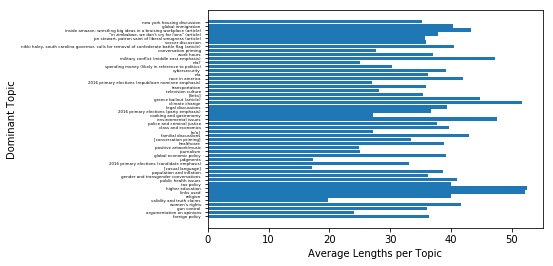

In [134]:
averagelengths=np.zeros((50))
numcomments=np.zeros(50)
for sampleidx in range(Xtest.shape[0]):
    topicidx=np.argmax(Xtest[sampleidx])
    averagelengths[topicidx]+=Ytest[sampleidx]
    numcomments[topicidx]+=1
averagelengths/=numcomments
print(averagelengths)
longest=np.argsort(averagelengths)[-5:]
longest=np.flip(longest)
print(longest)
feature_names=np.array(feature_names)
print(feature_names[longest])

import matplotlib.pyplot as plt


plt.barh(feature_names,averagelengths)
plt.yticks(fontsize=4)
plt.ylabel('Dominant Topic')
plt.xlabel('Average Lengths per Topic')
plt.savefig('./plots/AverageLengths.pdf',dpi=300)

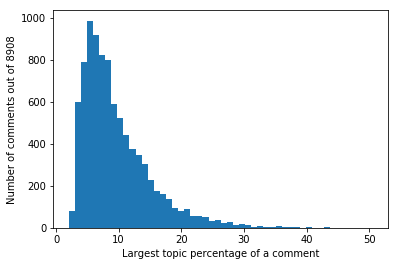

In [14]:
#topic distribution skewness
maxperc = []#largest topic percentage
for sampleidx in range(X.shape[0]):
    maxperc.append(np.max(X[sampleidx])*100)
import matplotlib.pyplot as plt
plt.hist(maxperc, bins = 50)
plt.ylabel('Number of comments out of '+str(X.shape[0]))
plt.xlabel('Largest topic percentage of a comment')
plt.savefig('./plots/maxpercentage.pdf',dpi=300)